* single-turn

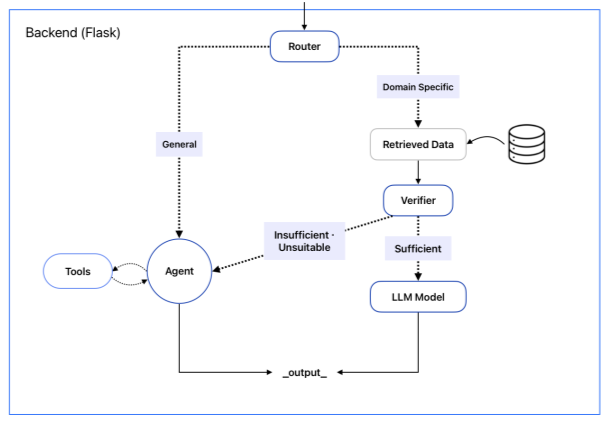

In [ ]:
import uuid, os
from dotenv import load_dotenv
from typing import TypedDict
from openai import OpenAI
from langchain_openai import ChatOpenAI
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_teddynote.messages import random_uuid   # type: ignore
## langsmith
from langsmith import Client
from langchain_teddynote import logging
from langchain_core.tracers.context import collect_runs

from langgraph.graph import END, StateGraph # type: ignore
from langgraph.checkpoint.memory import MemorySaver # type: ignore
from langgraph.errors import GraphRecursionError # type: ignore

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig  

from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

from langchain.agents import tool
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

## Flask
from flask import Flask, request, jsonify, g, session
from flask_restx import Api, Resource
from flask_cors import CORS

from langchain_teddynote import logging

# .env 파일 활성화 & API KEY 설정
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
logging.langsmith("rag_chatbot_test")

llm_4o = ChatOpenAI(model="gpt-4o", temperature=0)

class GraphState(TypedDict):
    question: str  # 질문
    q_type: str  # 질문의 유형
    context: list | str  # 문서의 검색 결과
    answer: str | list[str]   # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)

store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환
    
#######################################################################
############################ nodes: Router ############################
#######################################################################

# 자료구조 정의 (pydantic)
class Router(BaseModel):
    type: str = Field(description="type of the query that model choose")

# 출력 파서 정의
router_output_parser = JsonOutputParser(pydantic_object=Router)
format_instructions = router_output_parser.get_format_instructions()

# prompt 구성
router_prompt = PromptTemplate(
    template="""
            You are an expert who classifies the type of question. There are two query types: [‘general’, ‘domain_specific’]

            [general]
            Questions unrelated to addresses, such as translating English to Korean, asking for general knowledge (e.g., “What is the capital of South Korea?”), or queries that can be answered through a web search.

            [domain_specific]
            Questions related to addresses, such as concepts, definitions, address-related data analysis, or reviewing properly written addresses (e.g., “수지구는 자치구이니 일반구이니?”, “특별시에 대해서 설명해줘”, “주소와 주소정보의 차이점은?”).

            <Output format>: Always respond with either “general” or “domain_specific” and nothing else. {format_instructions}
            
            <Question>: {query} 
            """,
    input_variables=["query"],
    partial_variables={"format_instructions": format_instructions},
)

def router(state: GraphState) -> GraphState:
    chain = router_prompt | llm_4o | router_output_parser
    
    router_result = chain.invoke({"query": state["question"]})
    state["q_type"] = router_result['type']
    return state

def router_conditional_edge(state: GraphState) -> GraphState:
    q_type = state["q_type"].strip()
    return q_type

##################################################################################
############################ nodes: Retrieve Document ############################
##################################################################################

client = chromadb.PersistentClient('chroma/')
embedding = OpenAIEmbeddings(model='text-embedding-3-large')  
vectorstore = Chroma(client=client, collection_name="49_files_openai_3072", embedding_function=embedding)

def retrieve_document(state: GraphState) -> GraphState:
    retrieved_docs = vectorstore.similarity_search_with_score(state["question"], k=3)
    return {**state, "context": retrieved_docs} 

#########################################################################
############################ nodes: Verifier ############################
#########################################################################

# 자료구조 정의 (pydantic)
class Verifier(BaseModel):
    type: str = Field(description="verify that retrieved data is sufficient to answer the query")

# 출력 파서 정의
verifier_output_parser = JsonOutputParser(pydantic_object=Verifier)
format_instructions = verifier_output_parser.get_format_instructions()

verifier_prompt = PromptTemplate(
    template="""
            You are an expert who verity the retrieved data's quality and usefullness to answer the query. There are two query types: [‘sufficient’, ‘insufficient’, 'unsuitable']

            [sufficient]
            When the retrieved data is sufficient to answer the query.
            
            [insufficient]
            When the retrieved data is insufficient to answer the query, triggering additional actions or tool usage:
            1.	When the context information is inadequate to respond to the query, requiring further steps (e.g., search).
            2.	When the query involves tasks beyond simple address-related information retrieval, such as report generation or image creation.

            [unsuitable]
            When the retrieved data is not suitable to answer the query.
            
            <Output format>: Always respond with either "sufficient", "insufficient" or "unsuitable" and nothing else. {format_instructions}
            
            <Question>: {query} 
            <Retrieved data>: {retrieved_data}
            """,
    input_variables=["query", "retrieved_data"],
    partial_variables={"format_instructions": format_instructions},
)

def verifier(state: GraphState) -> GraphState:
    chain = verifier_prompt | llm_4o | verifier_output_parser
    verified = chain.invoke({"query": state["question"], "retrieved_data": state["context"]})
    state["relevance"] = verified['type']
    return state

def verifier_conditional_edge(state: GraphState) -> str:
    verified_result = state["relevance"].strip()
    
    if verified_result not in ["sufficient", "insufficient", "unsuitable"]:
        raise ValueError(f"Unexpected verifier result: {verified_result}")

    return verified_result

##########################################################################
############################ nodes: LLM Model ############################
##########################################################################

# 자료구조 정의 (pydantic)
class LLM_Model(BaseModel):
    result: str = Field(description="answer the query based on the retrieved data")
    reference: list = Field(description="reference that retrieved data is based on. If there is multiple references, list all of them.")

# 출력 파서 정의
model_output_parser = JsonOutputParser(pydantic_object=LLM_Model)
format_instructions = model_output_parser.get_format_instructions()

model_prompt = PromptTemplate(
    template="""
        You are an expert who answers the query based on the retrieved data.
        <Question>: {query}
        <Retrieved data>: {retrieved_data}

        Your response must be in the following JSON format:
        {format_instructions}
    """,
    input_variables=["query", "retrieved_data"],
    partial_variables={"format_instructions": format_instructions},
)

def llm_model(state: GraphState) -> GraphState:
    chain = model_prompt | llm_4o | model_output_parser
    answer = chain.invoke({"query": state["question"], "retrieved_data": state["context"]})
    state["answer"] = answer['result']
    return state

############################ tools ############################

@tool
def search_on_web(input):
    """ 실시간 정보, 최신 정보 등 웹 검색이 필요한 질문에 답변하기 위해 사용하는 도구 """
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": input})

    return search_result

@tool
def image_generator(input):
    """ 이미지 생성기 """
    client = OpenAI()
    response = client.images.generate(
        model="dall-e-3",
        prompt=input,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    
    image_url = response.data[0].url
    return image_url

@tool
def advanced_assistant(input, retrieved_data):
    """ 고급 기능(예: 긴 문서 생성, 추론이 필요한 답변 등)을 수행할 수 있는 모델 """
    client = OpenAI()
 
    response = client.chat.completions.create(
        model="o1",
        messages=[
            { "role": "developer", "content": "You are a helpful assistant." },
            {
                "role": "user", 
                "content": input
            }
        ]
    )
    
    result = response.choices[0].message.content
    return result

@tool
def image_explainer(query, image_url):
    """ 이미지 설명 생성기. Use after the image_generator tool make the image output. Use the url of the image_generator tool. """
    client = OpenAI()  # Client 객체 생성

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": query},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_url,
                        },
                    },
                ],
            }
        ],
        max_tokens=300,
    )
    return response.choices[0]
    

tools = [search_on_web, image_generator, advanced_assistant, image_explainer]

agent_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a helpful assistant, and you use Korean.
            Make sure to use the appropriate tools for the task.
            1.	You can appropriately select and use various tools based on the situation.
                (Note) When the user asks for current information, consider “February 2025” as the reference point for up-to-date data.
            2.	If the relevance is “insufficient,” use the retrieved_data along with the search_on_web tool.
            3.	If you use the advanced_assistant tool, make sure to reflect both the content and the full extent of the response in your final answer.
            4.	If you use the image_generator tool, you must also use the image_explainer tool to provide a description of the generated image.
            5.	(IMPORTANT) The user may have multiple requests, and you must generate a response that addresses all of them.
                - If multiple tools are required to fulfill different aspects of the user’s request, combine the results comprehensively into a single, final response.
                - If an image is generated, you must include both the image URL and a detailed explanation of the image.
                - Ensure that all tool outputs are fully incorporated into the final answer.
            """
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

def agent(state: GraphState) -> GraphState:
    
    agent = create_tool_calling_agent(llm_4o, tools, agent_prompt)
    
    agent_executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=False,
        max_iterations=100,
        max_execution_time=100,
        handle_parsing_errors=True,
        return_intermediate_steps=True
    )
    
    tool_input = {"input": state["question"], "retrieved_data": state["context"], "relevance": state["relevance"]}

    result = agent_executor.invoke({"input": tool_input})
    
    final_result = result.copy()

    # # image_generator가 포함되어 있다면 그대로 출력
    # if any(step[0].tool == 'image_generator' for step in result['intermediate_steps']):
    #     final_result['output'] = result['output']
    # else:
    #     # 가장 마지막에 실행된 advanced_assistant의 결과 찾기
    #     for step in reversed(result['intermediate_steps']):
    #         if step[0].tool == 'advanced_assistant':
    #             final_result['output'] = step[1]
    #             break
    
    # state["answer"] = final_result.get("output", "No valid output found")
    
    state['answer'] = result['output']


    # if result["output"] == "Agent stopped due to max iterations.":
    #     state["answer"] = result.get("intermediate_steps", [])
    # else:
    #     state["answer"] = result["output"]

    return state

########################################################################
############################ Workflow Graph ############################
########################################################################


workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("router", router)  # 질문의 종류를 분류하는 노드를 추가합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("general_llm", agent)  # 일반 질문에 대한 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", verifier)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("llm_answer", llm_model)  # 답변을 생성하는 노드를 추가합니다.

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "router",  # 질문의 종류를 분류하는 노드에서 나온 결과를 기반으로 다음 노드를 선택합니다.
    router_conditional_edge,
    {
        "domain_specific": "retrieve",  #.
        "general": "general_llm",  # 
    },
)

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    verifier_conditional_edge,
    {
        "sufficient": "llm_answer",  # 관련성이 있으면 종료합니다.
        "insufficient": "general_llm",  # 답변하기에 부족하면 general_llm으로 이동합니다.
        "unsuitable": "general_llm",  # 관련성이 없으면 general_llm으로 이동합니다.
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료
workflow.add_edge("general_llm", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("router")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
graph = workflow.compile(checkpointer=memory)    

##############################################################################################################
################################################Chat Interface################################################
##############################################################################################################

app = Flask(__name__)
app.secret_key = os.getenv('FLASK_SECRET_KEY')

origins = ["http://hike.cau.ac.kr", "http://localhost:3000"]
CORS(app, resources={r"/*": {"origins": origins}}, supports_credentials=True)

current_user_id = None

@app.route('/set_user_id', methods=['POST', 'GET'])
def set_user_id():
    global current_user_id
    data = request.get_json()
    current_user_id = data.get('id')
    return jsonify({"status": "ID received successfully"})

@app.route('/', methods=['POST', 'GET'])
def stream_responses():
    if request.method == 'POST':
        with collect_runs() as cb:
            message = request.form.get('message')
            
            if not message:
                return jsonify({"error": "Message is required"}), 400
    
            config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid.uuid4().hex})  

            inputs = GraphState(
                question=message,
                q_type="",  # 초기값 제공
                context=[],
                answer="",
                relevance=""
            )

            final_state = None  # 최종 상태를 저장할 변수

            try:
                # for chunk in graph.stream(inputs, stream_mode="values", config=config):
                #     for state_key, state_value in chunk.items():
                #         if state_key == "messages":
                #             if isinstance(state_value, list) and state_value:
                #                 if hasattr(state_value[-1], "pretty_print"):
                #                     state_value[-1].pretty_print()
                #                 else:
                #                     # print(state_value[-1])
                #                     pass
                
                final_state = graph.invoke(inputs, stream_mode="values", config=config)
                answer_text = final_state["answer"]
                print(answer_text)
                
            except GraphRecursionError as e:
                print(f"Recursion limit reached: {e}")
                answer_text = "죄송합니다. 해당 질문에 대해서는 답변할 수 없습니다."
            except Exception as e:
                print(f"An error occurred: {e}")
                answer_text = "죄송합니다. 처리 중 오류가 발생했습니다."

            return jsonify(answer=answer_text)
        

langsmith_client = Client()

@app.route('/feedback', methods=['POST', 'GET'])
def handle_feedback():
    data = request.json
    print(f"Received data: {data}")
    score = data.get('score')
    run_id = data.get('run_id')  # Get run_id from JSON body

    if score is None:
        return jsonify({"message": "No feedback provided"}), 400

    if run_id is None:
        return jsonify({"message": "No run_id available"}), 400
    
    try:
        score_value = float(score)
        langsmith_client.create_feedback(
            run_id,
            key="feedback-key",
            score=score_value,
            comment="comment",
        )
        return jsonify({"message": "Feedback received"}), 200
    except Exception as e:
        print(f"An error occurred while handling feedback: {e}")
        return jsonify({"message": "An error occurred"}), 500

@app.route('/reset', methods=['POST', 'GET'])
def reset_store():
    global store, current_user_id
    # store를 빈 딕셔너리로 초기화
    store = {}
    
    # 초기 상태로 `GraphState` 객체를 리셋 (임의로 예제 상태를 제공)
    global initial_state
    initial_state = GraphState(
        question='',
        q_type='',
        context='',
        answer='',
        relevance='',
        chat_history=''
    )
    
    # current_user_id 초기화
    # current_user_id = None
    
    return jsonify({"status": "Store and GraphState reset successfully"})

if __name__ == '__main__':
    app.run('0.0.0.0', port=5000, debug=True)